In [183]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import *
import numpy as np
import math
import torch
import gpytorch
from sklearn.preprocessing import *

In [184]:
df=pd.read_excel("UGP_Data.xlsx",sheet_name="Data_Model")

In [185]:
df.head()

,wt%,salt [mM],tan delta,delta,Temp,n,noise_n,FD,noise_fd,tg,log_tg,noise_tg,time [h],G',"G""",avg_noise_tg,noise_log_tg,S,log_S,noise_S
0,2.8,0.0,0.469,0.438542,30,0.279184,NaN,2.243474,NaN,4332.000000,3.636688,NaN,71.9575,7.760626,3.706306,28.928000,1.461318,8.214593,0.914586,NaN
1,3.0,0.0,0.383,0.365766,30,0.232854,NaN,2.289626,NaN,2967.883333,3.472447,NaN,49.464722,16.086607,6.871555,28.928000,1.461318,16.823833,1.225925,NaN
2,3.2,0.0,0.372,0.356138,30,0.226724,NaN,2.295617,NaN,1672.450000,3.223353,NaN,27.874167,20.881245,8.530632,28.928000,1.461318,21.804691,1.338550,NaN
3,3.4,0.0,0.343,0.330425,30,0.210355,NaN,2.311486,NaN,796.066667,2.900949,NaN,13.267778,26.493461,9.972796,28.928000,1.461318,27.553845,1.440182,NaN
4,3.6,0.0,0.336,0.324149,30,0.206359,0.000857,2.315331,0.000824,649.033333,2.812267,48.841667,10.817222,31.042231,10.967994,48.841667,1.688790,32.253468,1.508576,9.100433


In [186]:
dfy=df[["wt%","salt [mM]","Temp"]]
dfx=df[["n","log_tg","log_S"]]

In [187]:
X=np.array(dfx)
y=np.array(dfy)
outputs=["wt(%)","Salt","Temp"]

In [188]:
sc_X=StandardScaler()
X_sc=sc_X.fit_transform(X)

In [189]:
print("X Scaler mean",sc_X.mean_)

X Scaler mean [0.36045261 2.52201917 0.32363501]


In [190]:
print("X Scaler var",sc_X.var_)

X Scaler var [0.01803499 0.37730585 0.74858488]


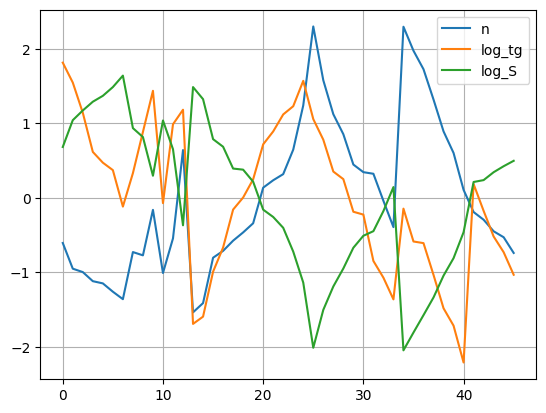

In [191]:
plt.plot(X_sc)
plt.legend(["n","log_tg","log_S"])
plt.grid()

In [192]:
sc_y=StandardScaler()
y_sc=sc_y.fit_transform(y)

In [193]:
print("Y Scaler mean",sc_y.mean_)

Y Scaler mean [ 2.5826087   3.24347826 30.        ]


In [194]:
print("Y Scaler var",sc_y.var_)

Y Scaler var [ 0.55100189  5.22941399 21.73913043]


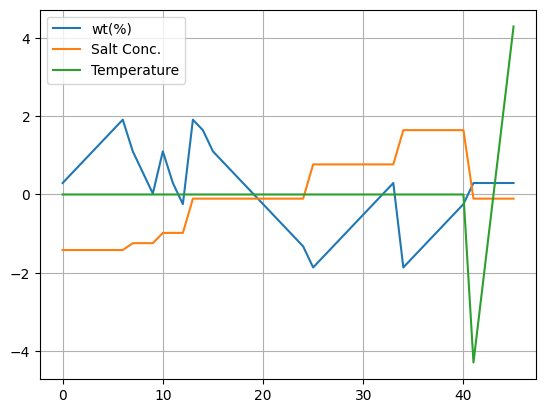

In [195]:
plt.plot(y_sc)
plt.legend(["wt(%)","Salt Conc.","Temperature"])
plt.grid()

In [196]:
X_sc=torch.tensor(X_sc)
y_sc=torch.tensor(y_sc)

In [197]:
n=0.2
log_tg=2.8
log_s=1.5
x_req=np.reshape(np.array([n,log_tg,log_s]),(1,-1))
x_req_sc=sc_X.transform(x_req)
x_req_sc=torch.tensor(x_req_sc)

## Homo Skedastic Noise Models - Independent Inference

## Gaussian Kernel

In [198]:
class GK_GP_Model(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GK_GP_Model, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [199]:
mean_gk=np.zeros((1,3))
lower_gk=np.zeros((1,3))
upper_gk=np.zeros((1,3))

In [200]:
for j in range(3):
    print("Training for ",outputs[j])
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model_gk = GK_GP_Model(X_sc,y_sc[:,j], likelihood)
    training_iter=50
    
    model_gk.train()
    likelihood.train()
    
    # Use the adam optimizer
    optimizer_gk = torch.optim.Adam(model_gk.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_gk)
    
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer_gk.zero_grad()
        # Output from model
        output_gk = model_gk(X_sc)
        # Calc loss and backprop gradients
        loss_gk = -mll(output_gk, y_sc[:,j])
        loss_gk.backward()
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
             i + 1, training_iter, loss_gk.item(),
             model_gk.covar_module.base_kernel.lengthscale.item(),
             model_gk.likelihood.noise.item()
         ))
        optimizer_gk.step()
    lengthscale=model_gk.covar_module.base_kernel.lengthscale.item()
    noise = model_gk.likelihood.noise.item()
    print("Length scale for the trained RBF Kernel for ",outputs[j]," : ",lengthscale)
    print("Noise Parameter of the Gaussian likelihood for",outputs[j]," : ",noise)
    model_gk.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Obtain the predictive mean and covariance matrix
        f_preds_gk = model_gk(x_req_sc)
        f_mean_gk= f_preds_gk.mean
        f_cov_gk = f_preds_gk.covariance_matrix

        # Make predictions by feeding model through likelihood
        observed_pred_gk = likelihood(model_gk(x_req_sc))
        lower, upper = observed_pred_gk.confidence_region()
        mean_gk[:,j]=observed_pred_gk.mean.numpy()
        lower_gk[:,j]=lower.numpy()
        upper_gk[:,j]=upper.numpy()

Training for  wt(%)
Iter 1/50 - Loss: 1.152   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.108   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.067   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 1.027   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 0.986   lengthscale: 0.913   noise: 0.513
Iter 6/50 - Loss: 0.944   lengthscale: 0.973   noise: 0.474
Iter 7/50 - Loss: 0.902   lengthscale: 1.036   noise: 0.437
Iter 8/50 - Loss: 0.859   lengthscale: 1.101   noise: 0.402
Iter 9/50 - Loss: 0.816   lengthscale: 1.167   noise: 0.370
Iter 10/50 - Loss: 0.773   lengthscale: 1.236   noise: 0.339
Iter 11/50 - Loss: 0.730   lengthscale: 1.305   noise: 0.311
Iter 12/50 - Loss: 0.688   lengthscale: 1.376   noise: 0.284
Iter 13/50 - Loss: 0.645   lengthscale: 1.447   noise: 0.260
Iter 14/50 - Loss: 0.603   lengthscale: 1.520   noise: 0.237
Iter 15/50 - Loss: 0.562   lengthscale: 1.592   noise: 0.216
Iter 16/50 - Loss: 0.520   lengthscale: 1.666   noise: 0.197
Iter 17/50 - 

Iter 1/50 - Loss: 1.138   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.093   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 1.051   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 1.011   lengthscale: 0.854   noise: 0.554
Iter 5/50 - Loss: 0.971   lengthscale: 0.912   noise: 0.513
Iter 6/50 - Loss: 0.931   lengthscale: 0.973   noise: 0.474
Iter 7/50 - Loss: 0.891   lengthscale: 1.035   noise: 0.437
Iter 8/50 - Loss: 0.850   lengthscale: 1.099   noise: 0.402
Iter 9/50 - Loss: 0.809   lengthscale: 1.165   noise: 0.370
Iter 10/50 - Loss: 0.768   lengthscale: 1.232   noise: 0.339
Iter 11/50 - Loss: 0.727   lengthscale: 1.300   noise: 0.311
Iter 12/50 - Loss: 0.687   lengthscale: 1.370   noise: 0.285
Iter 13/50 - Loss: 0.647   lengthscale: 1.440   noise: 0.260
Iter 14/50 - Loss: 0.607   lengthscale: 1.510   noise: 0.238
Iter 15/50 - Loss: 0.567   lengthscale: 1.582   noise: 0.217
Iter 16/50 - Loss: 0.528   lengthscale: 1.653   noise: 0.197
Iter 17/50 - Loss: 0.489   length

In [201]:
mean_gk_org_dim=sc_y.inverse_transform(mean_gk)
lower_gk_org_dim=sc_y.inverse_transform(lower_gk)
upper_gk_org_dim=sc_y.inverse_transform(upper_gk)

In [202]:
print("In the transformed Space:")
print("Weight %. , Salt Conc. , Temperature")
print(mean_gk)
print("In the actual Space:")
print("Weight %. , Salt Conc. , Temperature")
print(mean_gk_org_dim)

In the transformed Space:
Weight %. , Salt Conc. , Temperature
[[ 1.33192703 -1.37055698  0.003296  ]]
In the actual Space:
Weight %. , Salt Conc. , Temperature
[[ 3.57129149  0.10930062 30.01536769]]


In [203]:
lower_gk_org_dim

array([[ 3.40642461, -0.51707091, 21.18950107]])

In [204]:
upper_gk_org_dim

array([[ 3.73615837,  0.73567214, 38.84123432]])

## MOGP-Joint Inference

In [205]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=3
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=3, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood_mogp = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)

In [206]:
X_32_sc=X_sc.to(torch.float32)
y_32_sc=y_sc.to(torch.float32)
x_req_32_sc=x_req_sc.to(torch.float32)

In [207]:
model_mogp = MultitaskGPModel(X_32_sc,y_32_sc,likelihood_mogp)

In [208]:
training_iterations =50


# Find optimal model hyperparameters
model_mogp.train()
likelihood_mogp.train()

# Use the adam optimizer
optimizer_mogp = torch.optim.Adam(model_mogp.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll_mogp = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_mogp, model_mogp)

for i in range(training_iterations):
    optimizer_mogp.zero_grad()
    output_mogp = model_mogp(X_32_sc)
    loss_mogp = -mll_mogp(output_mogp,y_32_sc)
    loss_mogp.backward()
    optimizer_mogp.step()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [209]:
mean_params = model_mogp.mean_module.state_dict()
covar_params = model_mogp.covar_module.task_covar_module.covar_matrix.numpy()
print('Mean Parameters of the trained MOGP Model')
print(mean_params)
print('Covarinace Parameters of the trained MOGP Model')
print(covar_params)

Mean Parameters of the trained MOGP Model
OrderedDict([('base_means.0.raw_constant', tensor(-0.0125)), ('base_means.1.raw_constant', tensor(0.2674)), ('base_means.2.raw_constant', tensor(0.0199))])
Covarinace Parameters of the trained MOGP Model
[[ 3.5865226  -2.905535   -0.12536265]
 [-2.905535    3.8670428   0.14617951]
 [-0.12536265  0.14617951  0.02698877]]


In [210]:
# Set into eval mode
model_mogp.eval()
likelihood_mogp.eval()


# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions_mogp = likelihood_mogp(model_mogp(x_req_32_sc))
    mean_mogp = predictions_mogp.mean
    lower_mogp, upper_mogp = predictions_mogp.confidence_region()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [211]:
mean_mogp_org_dim=sc_y.inverse_transform(mean_mogp)
lower_mogp_org_dim=sc_y.inverse_transform(lower_mogp)
upper_mogp_org_dim=sc_y.inverse_transform(upper_mogp)

In [212]:
print("In the transformed Space:")
print("Weight %. , Salt Conc. , Temperature")
print(mean_mogp)
print("In the actual Space:")
print("Weight %. , Salt Conc. , Temperature")
print(mean_mogp_org_dim)

In the transformed Space:
Weight %. , Salt Conc. , Temperature
tensor([[ 1.3337, -1.3647, -0.0438]])
In the actual Space:
Weight %. , Salt Conc. , Temperature
[[ 3.57261451  0.1226317  29.79559784]]


In [213]:
lower_mogp_org_dim

array([[ 3.37244936, -0.52717338, 20.65093955]])

In [214]:
upper_mogp_org_dim

array([[ 3.77277965,  0.77243679, 38.94025654]])